# ***Waze Churn Prediction***


In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Dataset

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats

df = pd.read_csv("/content/waze_dataset.csv")

# Statistical Analysis & Diagnostics

**Basic Exploration**

In [169]:
print("Shape of dataset:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nDescriptive Statistics:\n", df.describe(include="all"))

Shape of dataset: (14999, 13)

Data Types:
 ID                           int64
label                       object
sessions                     int64
drives                       int64
total_sessions             float64
n_days_after_onboarding      int64
total_navigations_fav1       int64
total_navigations_fav2       int64
driven_km_drives           float64
duration_minutes_drives    float64
activity_days                int64
driving_days                 int64
device                      object
dtype: object

Missing Values:
 ID                           0
label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64

Descriptive Statistics:
                   ID     la

**Descriptive Statistics**

In [170]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


**Target Variable Analysis**

/tmp/ipython-input-1732346721.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="Set2")


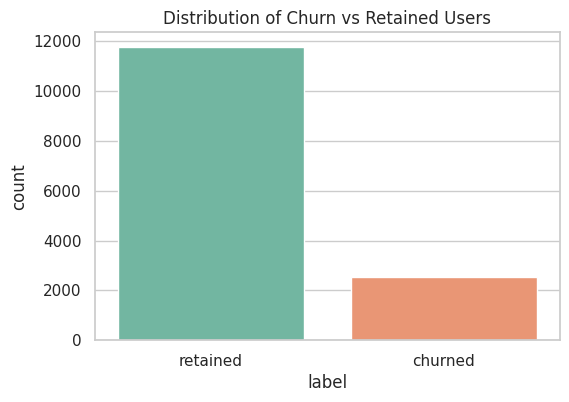

In [171]:
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df, palette="Set2")
plt.title("Distribution of Churn vs Retained Users")
plt.show()

**Numerical Feature Analysis**

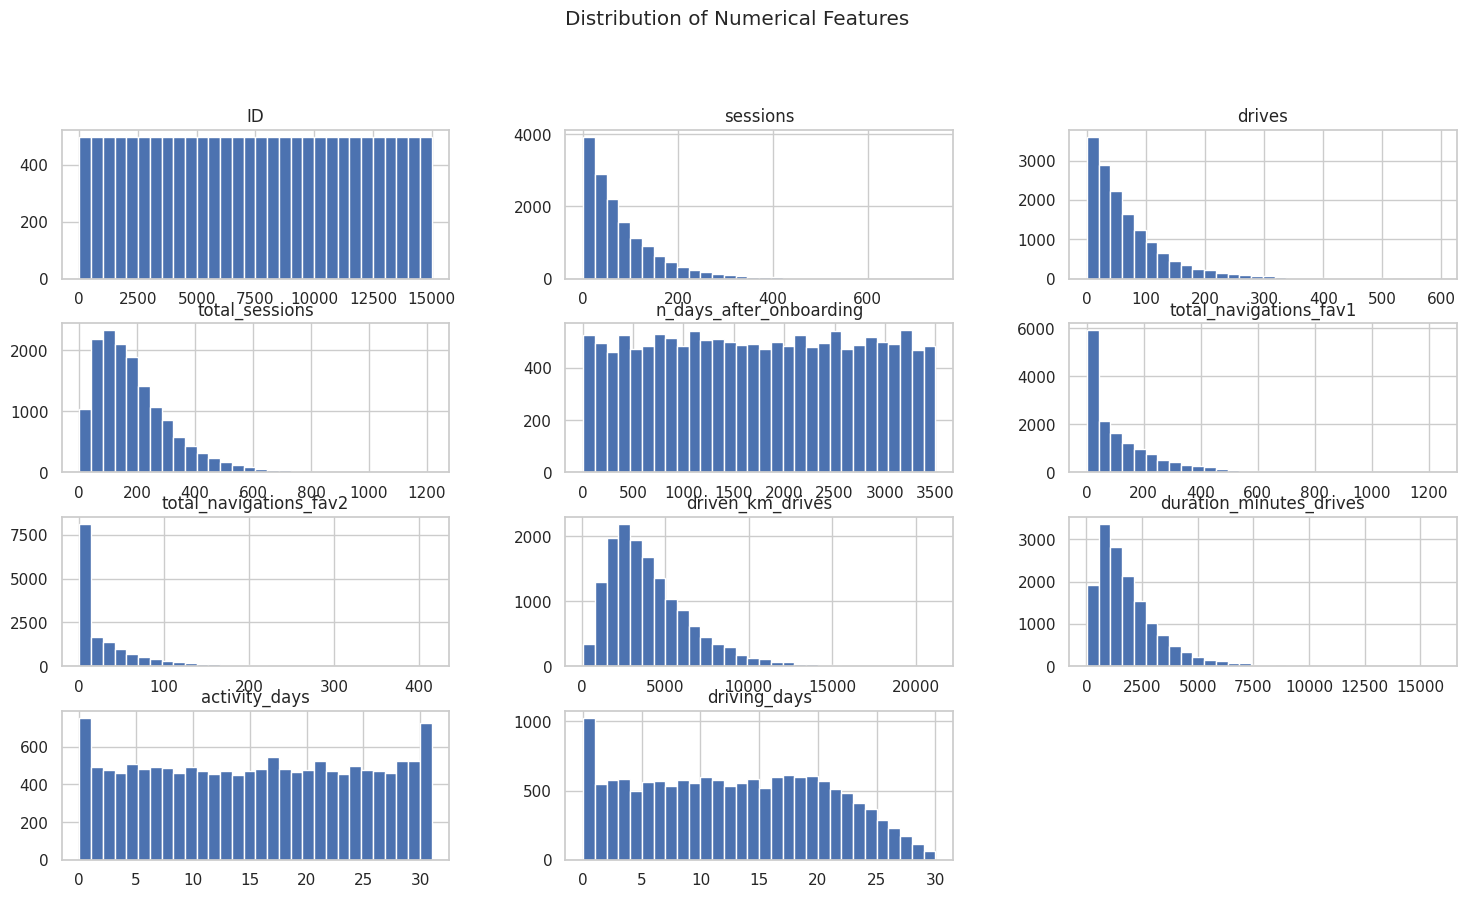

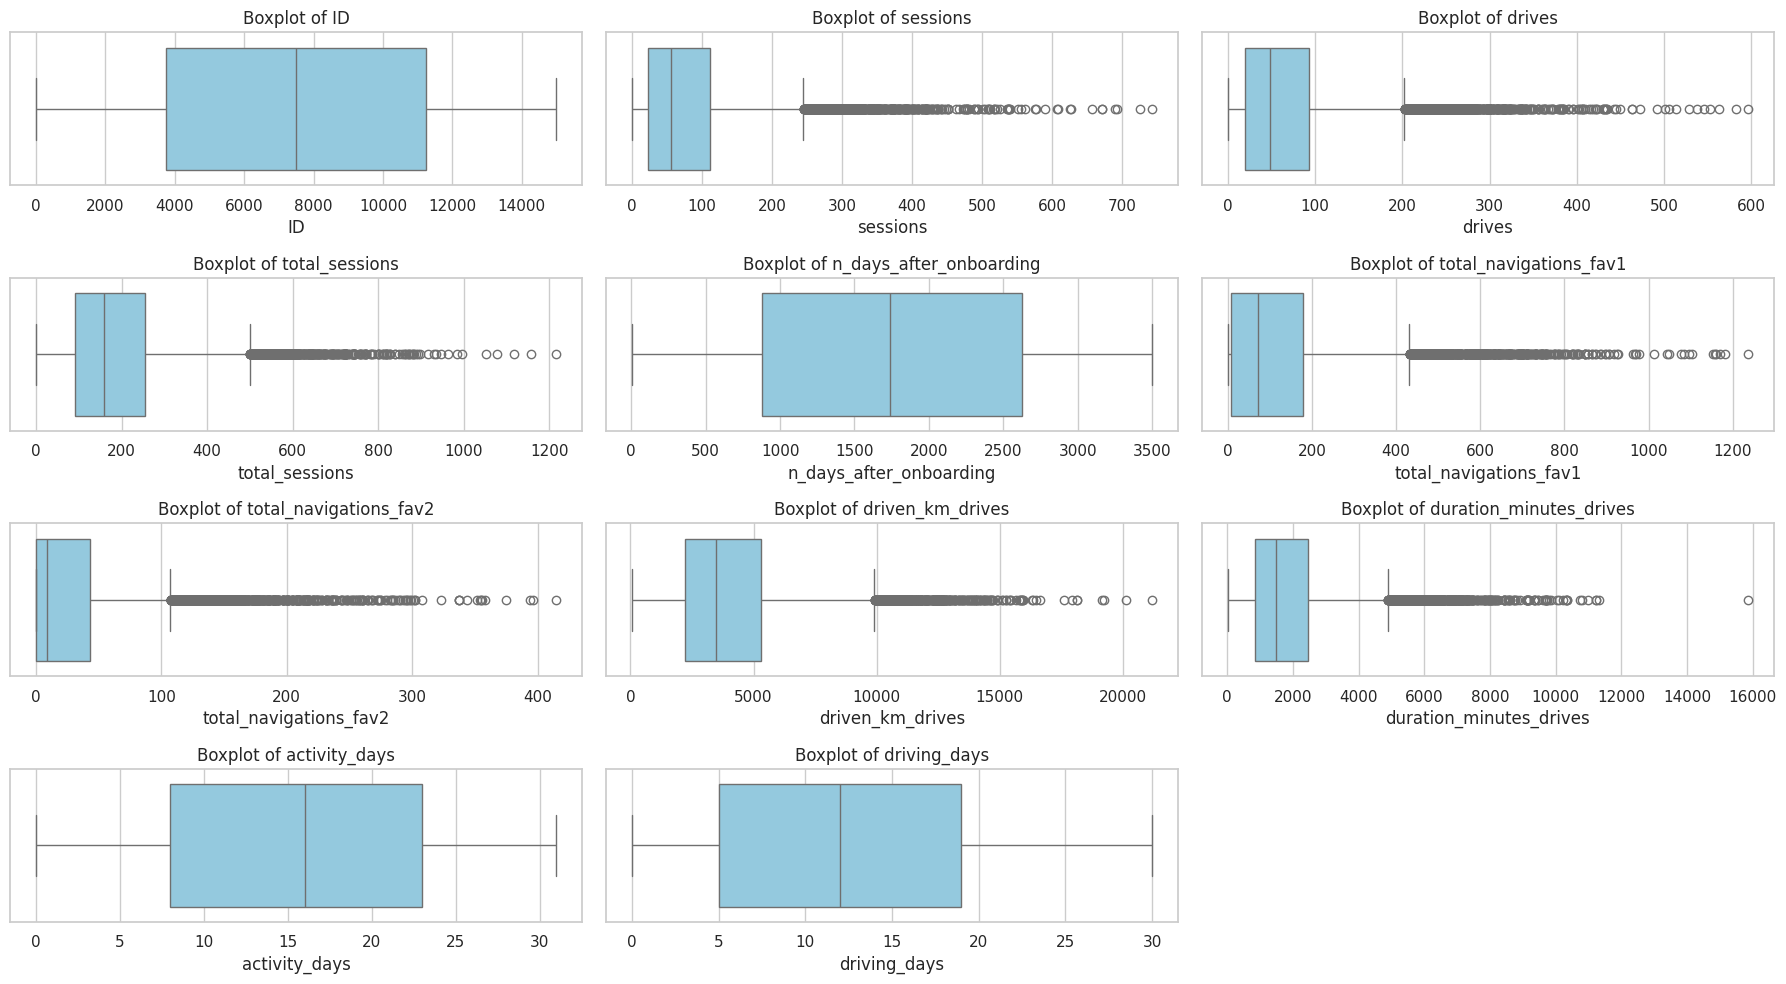

In [172]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Histograms
df[num_cols].hist(bins=30, figsize=(18,12), layout=(5,3))
plt.suptitle("Distribution of Numerical Features")
plt.show()

# Boxplots for outlier detection
plt.figure(figsize=(18,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

**Categorical Feature Analysis**

/tmp/ipython-input-2124727983.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="viridis")


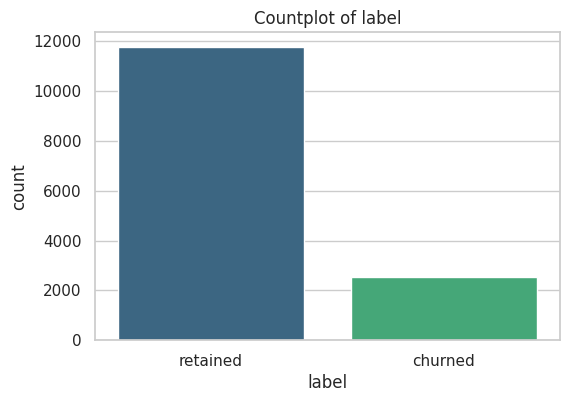

/tmp/ipython-input-2124727983.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="viridis")


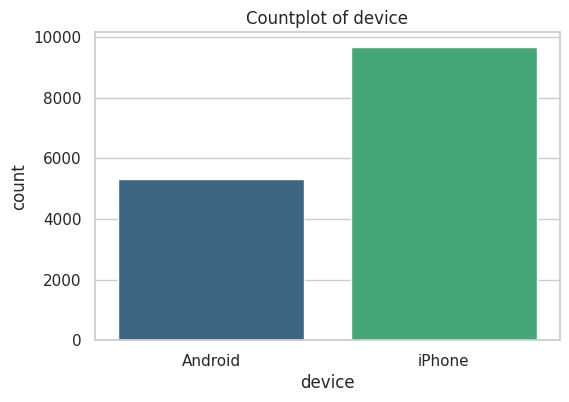

In [173]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, palette="viridis")
    plt.title(f"Countplot of {col}")
    plt.show()

**Correlation & HeatMap**

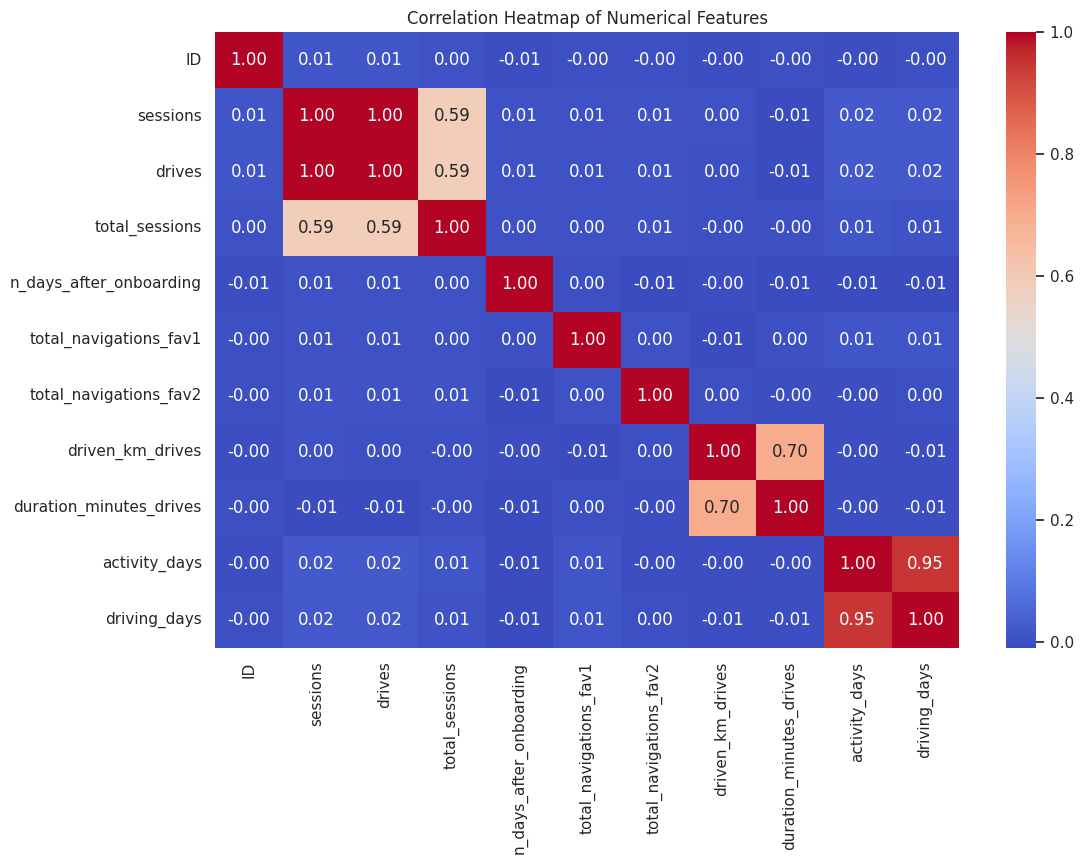

In [174]:
plt.figure(figsize=(12,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

**Statistical Test**

In [175]:
# T-test: Activity days between churned vs retained
df_clean = df.dropna(subset=["label"]).copy()
df_clean["churned"] = df_clean["label"].map({"churned":1, "retained":0})

churned = df_clean[df_clean["churned"]==1]["activity_days"]
retained = df_clean[df_clean["churned"]==0]["activity_days"]

t_stat, p_val = stats.ttest_ind(churned, retained, equal_var=False)
print(f"T-test Activity Days (Churned vs Retained): t={t_stat:.2f}, p={p_val:.5f}")

# Chi-square test: Device vs Churn
contingency = pd.crosstab(df_clean["device"], df_clean["churned"])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-Square Test (Device vs Churn): chi2={chi2:.2f}, p={p:.5f}")


T-test Activity Days (Churned vs Retained): t=-41.44, p=0.00000

Chi-Square Test (Device vs Churn): chi2=0.15, p=0.70072


**Diagnostics**

In [176]:
# Skewness & Kurtosis
print("\nSkewness and Kurtosis of Numerical Features:")
for col in num_cols:
    print(f"{col}: Skew={df[col].skew():.2f}, Kurtosis={df[col].kurt():.2f}")

# Outlier detection using Z-score
z_scores = np.abs(stats.zscore(df[num_cols]))
outliers = (z_scores > 3).sum()
print("\nOutliers detected per column (Z-score > 3):")
print(pd.Series(outliers, index=num_cols))


Skewness and Kurtosis of Numerical Features:
ID: Skew=0.00, Kurtosis=-1.20
sessions: Skew=2.01, Kurtosis=5.92
drives: Skew=1.97, Kurtosis=5.66
total_sessions: Skew=1.49, Kurtosis=3.34
n_days_after_onboarding: Skew=0.00, Kurtosis=-1.20
total_navigations_fav1: Skew=1.98, Kurtosis=5.20
total_navigations_fav2: Skew=2.42, Kurtosis=7.82
driven_km_drives: Skew=1.30, Kurtosis=2.35
duration_minutes_drives: Skew=1.77, Kurtosis=4.72
activity_days: Skew=-0.01, Kurtosis=-1.20
driving_days: Skew=0.10, Kurtosis=-1.08

Outliers detected per column (Z-score > 3):
ID                         1879
sessions                   1879
drives                     1879
total_sessions             1879
n_days_after_onboarding    1879
total_navigations_fav1     1879
total_navigations_fav2     1879
driven_km_drives           1879
duration_minutes_drives    1879
activity_days              1879
driving_days               1879
dtype: int64


# Data Cleaning

In [177]:
df_clean = df.dropna(subset=["label"]).copy()
df_clean['churned'] = df_clean['label'].map({'churned': 1, 'retained': 0})
df_clean['device_encoded'] = df_clean['device'].map({'Android': 0, 'iPhone': 1})
df_clean = df_clean.drop(columns=["ID", "label", "device"])

# Exploratory Data Analysis

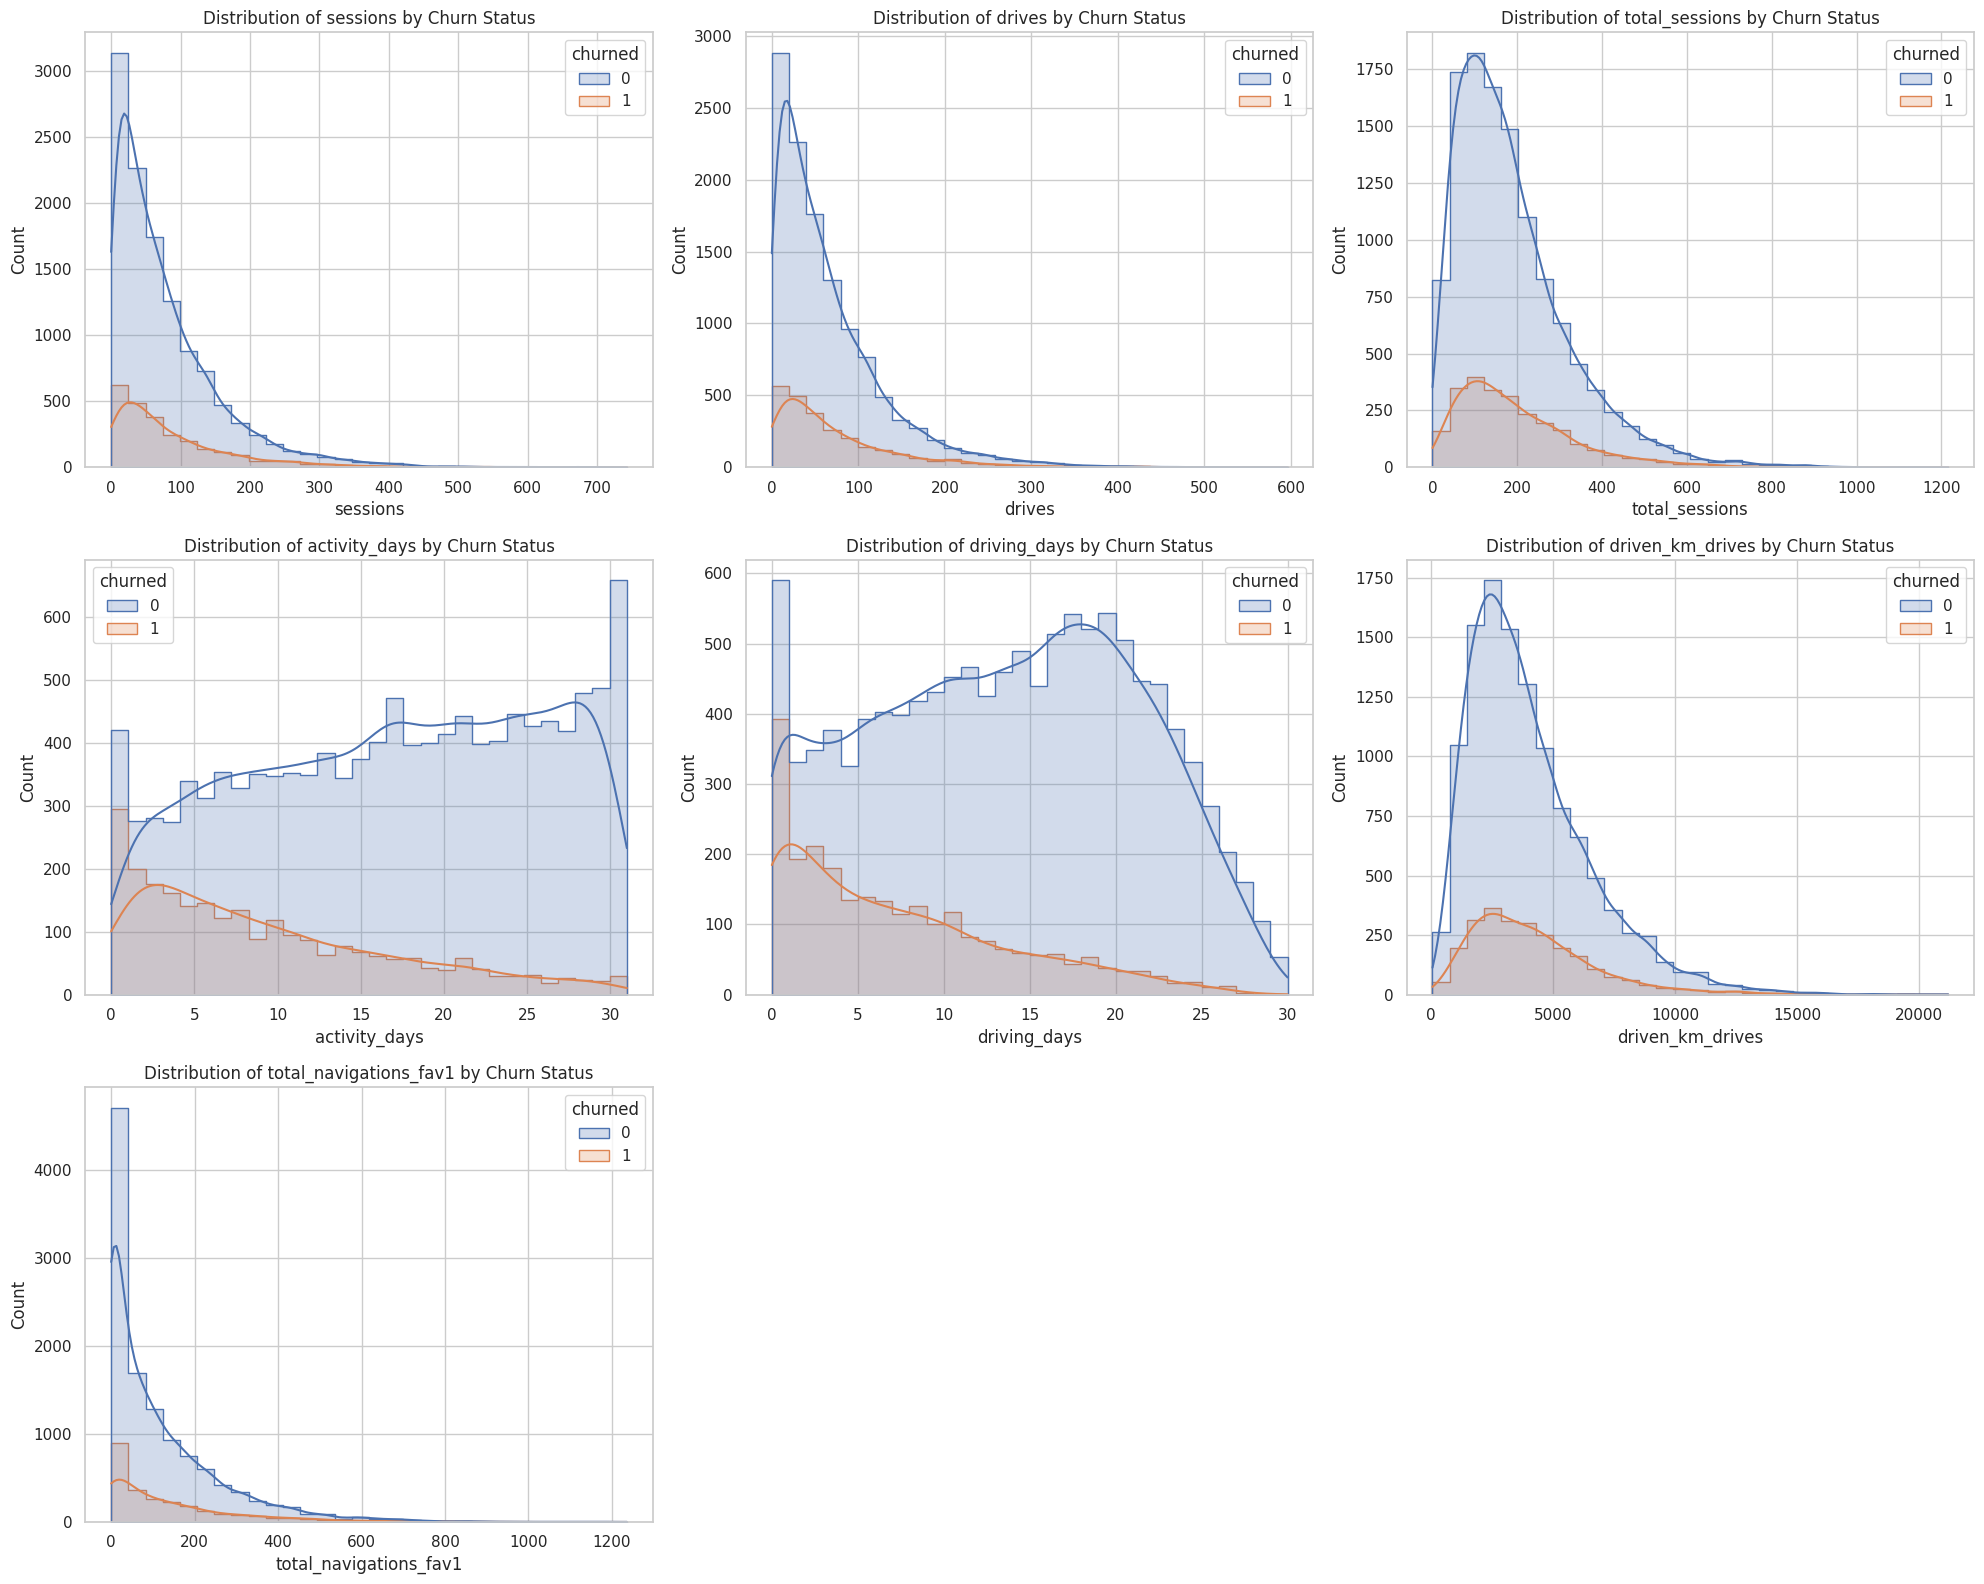

In [178]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 16))
features_to_plot = [
    "sessions", "drives", "total_sessions", "activity_days",
    "driving_days", "driven_km_drives", "total_navigations_fav1"
]
for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df_clean, x=feature, hue="churned", bins=30, kde=True, element="step")
    plt.title(f"Distribution of {feature} by Churn Status")
plt.tight_layout()
plt.show()

# Prediction Modeling

In [179]:
X = df_clean.drop(columns=["churned"])
y = df_clean["churned"]

**Train-test split**

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Logistic Regression

In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and fit the model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Evaluation
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Results:
Accuracy: 0.8249417249417249
Confusion Matrix:
 [[3468   39]
 [ 712   71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      3507
           1       0.65      0.09      0.16       783

    accuracy                           0.82      4290
   macro avg       0.74      0.54      0.53      4290
weighted avg       0.80      0.82      0.77      4290



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Feature Importance:
                    Feature  Coefficient
8             activity_days    -0.070371
9              driving_days    -0.039472
10           device_encoded    -0.024722
1                    drives     0.002810
5    total_navigations_fav2     0.001507
4    total_navigations_fav1     0.001144
0                  sessions    -0.000858
3   n_days_after_onboarding    -0.000371
7   duration_minutes_drives     0.000088
2            total_sessions     0.000053
6          driven_km_drives    -0.000014


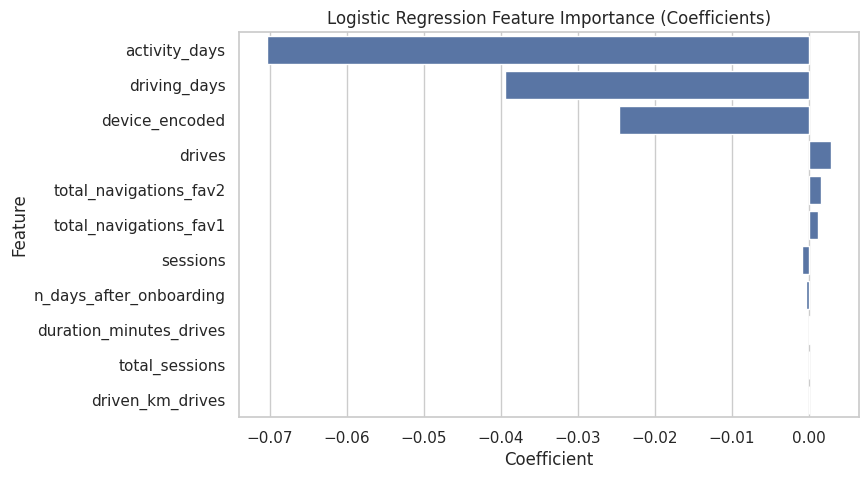

In [182]:
# Feature importance (Logistic Regression - coefficients)
importance = log_model.coef_[0]
features = X_train.columns
coef_df = pd.DataFrame({"Feature": features, "Coefficient": importance})
coef_df = coef_df.sort_values("Coefficient", key=abs, ascending=False)

print("\nLogistic Regression Feature Importance:")
print(coef_df)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Coefficient", y="Feature", data=coef_df)
plt.title("Logistic Regression Feature Importance (Coefficients)")
plt.show()

# 2. Decision Tree Classifier

In [183]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and fit the model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

# Evaluation
print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree Results:
Accuracy: 0.7303030303030303
Confusion Matrix:
 [[2898  609]
 [ 548  235]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      3507
           1       0.28      0.30      0.29       783

    accuracy                           0.73      4290
   macro avg       0.56      0.56      0.56      4290
weighted avg       0.74      0.73      0.73      4290




Decision Tree Feature Importance:
                    Feature  Importance
3   n_days_after_onboarding    0.140509
7   duration_minutes_drives    0.133817
8             activity_days    0.129075
2            total_sessions    0.121711
4    total_navigations_fav1    0.101411
6          driven_km_drives    0.099347
0                  sessions    0.072726
1                    drives    0.070853
5    total_navigations_fav2    0.063530
9              driving_days    0.051221
10           device_encoded    0.015799


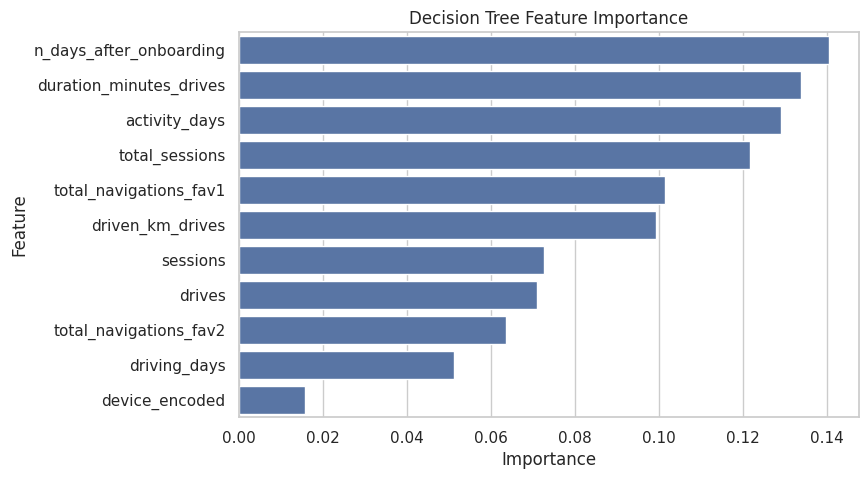

In [184]:
# Feature importance (Decision Tree)
importance = tree_model.feature_importances_
features = X_train.columns
tree_imp = pd.DataFrame({"Feature": features, "Importance": importance}).sort_values("Importance", ascending=False)

print("\nDecision Tree Feature Importance:")
print(tree_imp)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=tree_imp)
plt.title("Decision Tree Feature Importance")
plt.show()

# 3. Random Forest Classifier

In [185]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Results:
Accuracy: 0.8142191142191142
Confusion Matrix:
 [[3402  105]
 [ 692   91]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      3507
           1       0.46      0.12      0.19       783

    accuracy                           0.81      4290
   macro avg       0.65      0.54      0.54      4290
weighted avg       0.76      0.81      0.77      4290




Random Forest Feature Importance:
                    Feature  Importance
3   n_days_after_onboarding    0.125415
7   duration_minutes_drives    0.110088
8             activity_days    0.106006
6          driven_km_drives    0.105409
2            total_sessions    0.105397
4    total_navigations_fav1    0.094016
9              driving_days    0.091603
0                  sessions    0.089710
1                    drives    0.087309
5    total_navigations_fav2    0.069322
10           device_encoded    0.015724


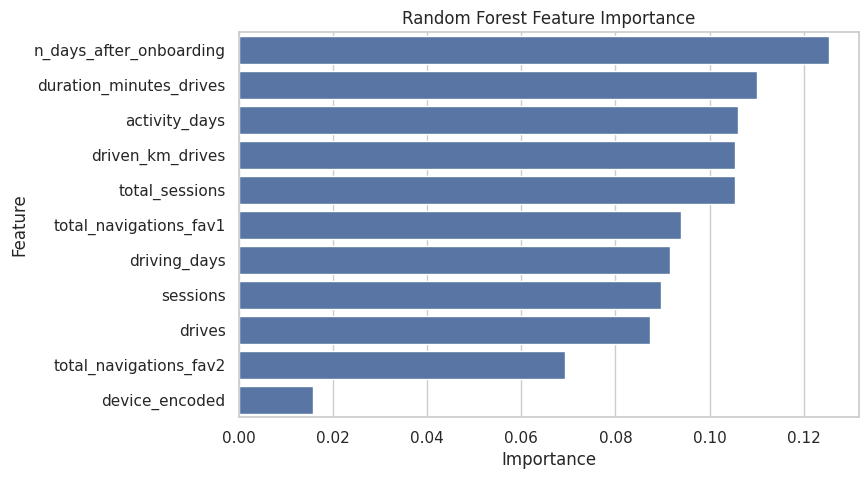

In [186]:
# Feature importance (Random Forest)
importance = rf_model.feature_importances_
features = X_train.columns
rf_imp = pd.DataFrame({"Feature": features, "Importance": importance}).sort_values("Importance", ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_imp)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=rf_imp)
plt.title("Random Forest Feature Importance")
plt.show()

# 4. XGBoost

In [187]:
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Create and train the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Classifier Results:\n")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:44:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier Results:

Confusion Matrix:
 [[3318  189]
 [ 650  133]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      3507
           1       0.41      0.17      0.24       783

    accuracy                           0.80      4290
   macro avg       0.62      0.56      0.56      4290
weighted avg       0.76      0.80      0.77      4290

Accuracy Score: 0.8044289044289045



XGBoost Feature Importance:
                    Feature  Importance
8             activity_days    0.240987
9              driving_days    0.109257
3   n_days_after_onboarding    0.082874
1                    drives    0.076648
4    total_navigations_fav1    0.075764
7   duration_minutes_drives    0.075350
2            total_sessions    0.069468
0                  sessions    0.069376
10           device_encoded    0.068437
6          driven_km_drives    0.066922
5    total_navigations_fav2    0.064916


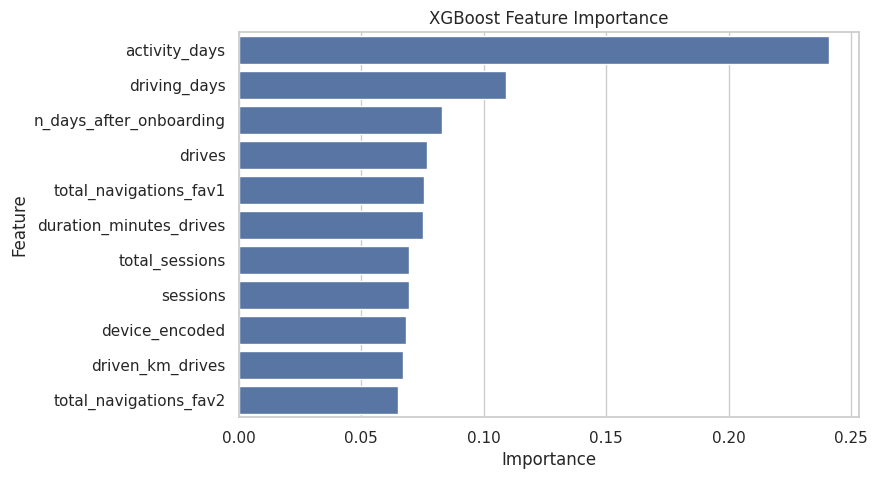

In [188]:
# Feature importance (XGBoost)
importance = xgb_model.feature_importances_
features = X_train.columns
xgb_imp = pd.DataFrame({"Feature": features, "Importance": importance}).sort_values("Importance", ascending=False)

print("\nXGBoost Feature Importance:")
print(xgb_imp)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=xgb_imp)
plt.title("XGBoost Feature Importance")
plt.show()

# Model Comparision

In [189]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix
)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

**Collect predictions & probabilities**

In [190]:
probas = {
    "Logistic Regression": log_model.predict_proba(X_test)[:, 1],
    "Decision Tree":       tree_model.predict_proba(X_test)[:, 1],
    "Random Forest":       rf_model.predict_proba(X_test)[:, 1],
    "XGBoost":             xgb_model.predict_proba(X_test)[:, 1],
}
preds = {
    "Logistic Regression": y_pred_log,
    "Decision Tree":       y_pred_tree,
    "Random Forest":       y_pred_rf,
    "XGBoost":             y_pred_xgb,
}

**Build a comparison table on the held-out test set**

In [191]:
rows = []
for name in preds:
    yhat = preds[name]
    yscore = probas[name]
    rows.append({
        "model": name,
        "accuracy": accuracy_score(y_test, yhat),
        "precision": precision_score(y_test, yhat, zero_division=0),
        "recall": recall_score(y_test, yhat, zero_division=0),
        "f1": f1_score(y_test, yhat, zero_division=0),
        "roc_auc": roc_auc_score(y_test, yscore),
        "avg_precision": average_precision_score(y_test, yscore),  # PR-AUC
    })
cmp_df = pd.DataFrame(rows).sort_values(["f1", "avg_precision", "roc_auc"], ascending=False)
print("\n=== Test-set performance (sorted by F1) ===")
print(cmp_df.to_string(index=False))


=== Test-set performance (sorted by F1) ===
              model  accuracy  precision   recall       f1  roc_auc  avg_precision
      Decision Tree  0.730303   0.278436 0.300128 0.288875 0.563238       0.211305
            XGBoost  0.804429   0.413043 0.169860 0.240724 0.704163       0.325525
      Random Forest  0.814219   0.464286 0.116220 0.185904 0.731229       0.357110
Logistic Regression  0.824942   0.645455 0.090677 0.159015 0.762526       0.410383


**ROC curves**

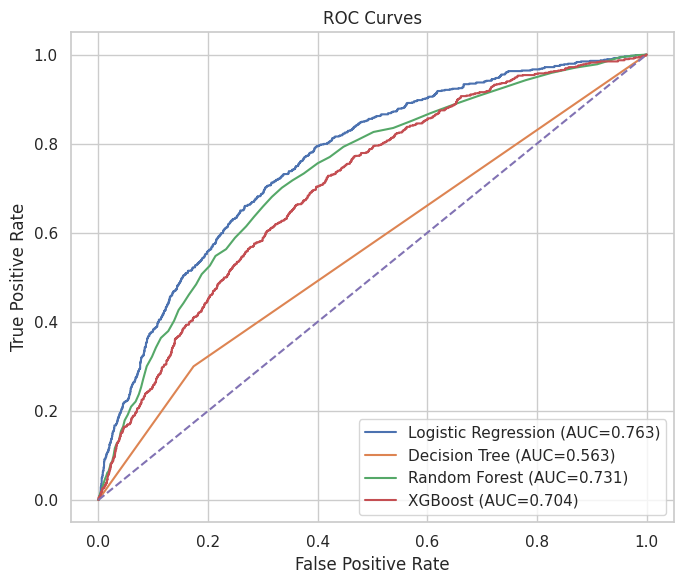

In [192]:
plt.figure(figsize=(7,6))
for name, yscore in probas.items():
    fpr, tpr, _ = roc_curve(y_test, yscore)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, yscore):.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()

**Precision-Recall curves**

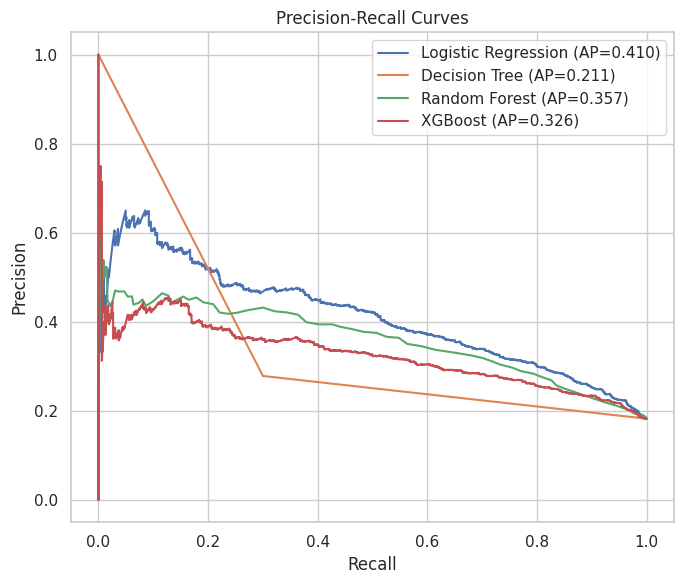

In [193]:
plt.figure(figsize=(7,6))
for name, yscore in probas.items():
    p, r, _ = precision_recall_curve(y_test, yscore)
    ap = average_precision_score(y_test, yscore)
    plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.tight_layout()
plt.show()

**Confusion matrix heatmaps for each model**

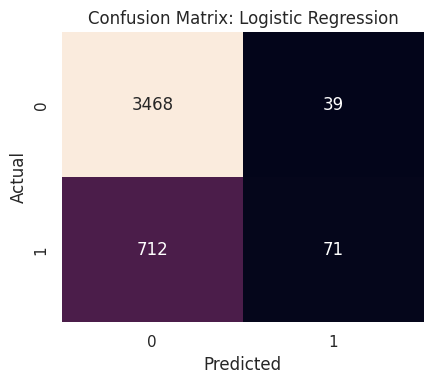

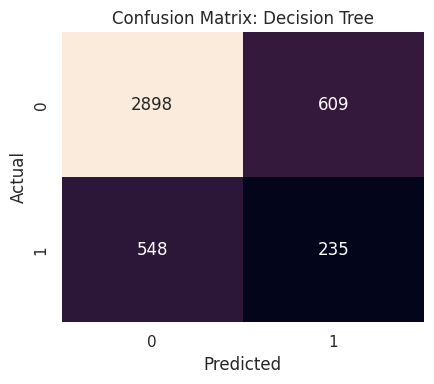

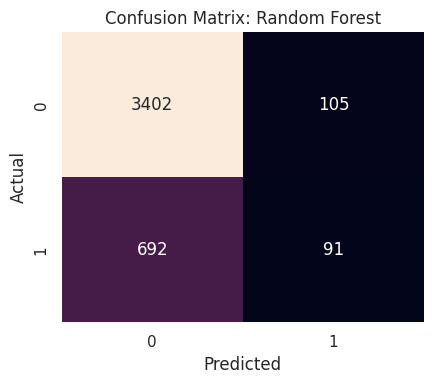

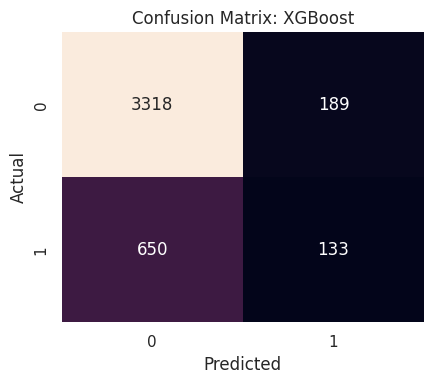

In [194]:
for name, yhat in preds.items():
    cm = confusion_matrix(y_test, yhat)
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


**5-fold cross-validation on the full dataset**

In [195]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "avg_precision": "average_precision",
}

cv_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree":       DecisionTreeClassifier(random_state=42),
    "Random Forest":       RandomForestClassifier(random_state=42),
    "XGBoost":             XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
}

cv_rows = []
for name, est in cv_models.items():
    res = cross_validate(est, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    cv_rows.append({
        "model": name,
        **{f"cv_{k}_mean": np.mean(res[f"test_{k}"]) for k in scoring.keys()},
        **{f"cv_{k}_std":  np.std(res[f"test_{k}"])  for k in scoring.keys()},
    })
cv_df = pd.DataFrame(cv_rows).sort_values("cv_f1_mean", ascending=False)
print("\n=== 5-fold Cross-Validation (means ± std) ===")
cols_show = ["model"] + [f"cv_{m}_mean" for m in scoring.keys()] + [f"cv_{m}_std" for m in scoring.keys()]
print(cv_df[cols_show].to_string(index=False))



=== 5-fold Cross-Validation (means ± std) ===
              model  cv_accuracy_mean  cv_precision_mean  cv_recall_mean  cv_f1_mean  cv_roc_auc_mean  cv_avg_precision_mean  cv_accuracy_std  cv_precision_std  cv_recall_std  cv_f1_std  cv_roc_auc_std  cv_avg_precision_std
      Decision Tree          0.732080           0.267071        0.292576    0.279210         0.559704               0.204041         0.008337          0.020659       0.022186   0.021159        0.013393              0.008015
            XGBoost          0.811455           0.419474        0.165605    0.237250         0.698983               0.324420         0.001414          0.012760       0.014735   0.016680        0.003905              0.007035
      Random Forest          0.819288           0.463498        0.113160    0.181547         0.719897               0.348310         0.004571          0.045564       0.013986   0.020206        0.008385              0.018081
Logistic Regression          0.825513           0.551386 

# Model Selection

**1. Model selection with F1 Score**

In [196]:
# Compare based on F1
scores = {
    "Logistic Regression": f1_score(y_test, y_pred_log),
    "Decision Tree": f1_score(y_test, y_pred_tree),
    "Random Forest": f1_score(y_test, y_pred_rf),
    "XGBoost": f1_score(y_test, y_pred_xgb),
}

# Find the best model
best_model = max(scores, key=scores.get)
print("\nBest Model Based on F1 Score:")
print(best_model, "with F1 =", scores[best_model])


Best Model Based on F1 Score:
Decision Tree with F1 = 0.28887523048555624


**2. Model selection with Accuracy Score**

In [197]:
# Compute scores
accuracy_scores = {name: accuracy_score(y_test, yhat) for name, yhat in preds.items()}
roc_auc_scores = {name: roc_auc_score(y_test, yprob) for name, yprob in probas.items()}

# Find best by Accuracy
best_acc_model = max(accuracy_scores, key=accuracy_scores.get)
print("\n🏆 Best Model by Accuracy:")
print(best_acc_model, "with Accuracy =", accuracy_scores[best_acc_model])



🏆 Best Model by Accuracy:
Logistic Regression with Accuracy = 0.8249417249417249


**3. Model selection with ROC-AUC**

In [198]:
# Compute scores
roc_auc_scores = {name: roc_auc_score(y_test, yprob) for name, yprob in probas.items()}

# Find best by ROC-AUC
best_auc_model = max(roc_auc_scores, key=roc_auc_scores.get)
print("\n🏆 Best Model by ROC-AUC:")
print(best_auc_model, "with ROC-AUC =", roc_auc_scores[best_auc_model])



🏆 Best Model by ROC-AUC:
Logistic Regression with ROC-AUC = 0.7625260335013244


# Data Visualizations

**Comparision between churned Users and Retained Users - Visualizations**

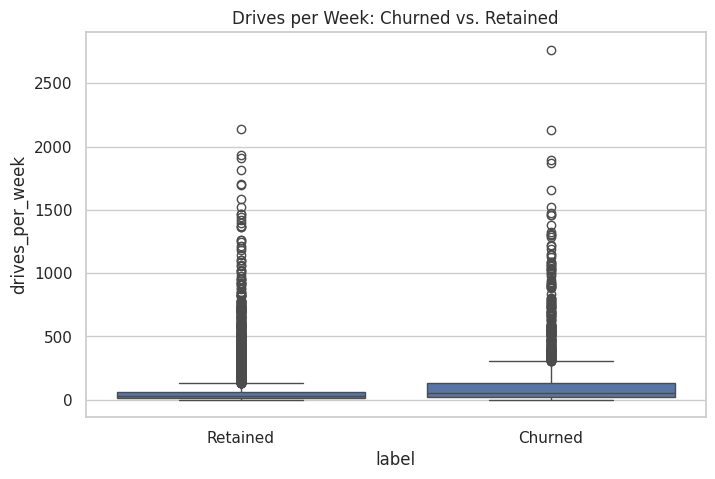

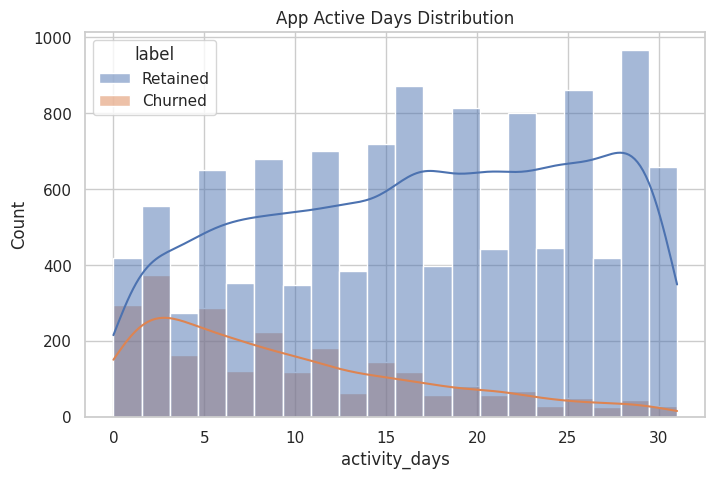

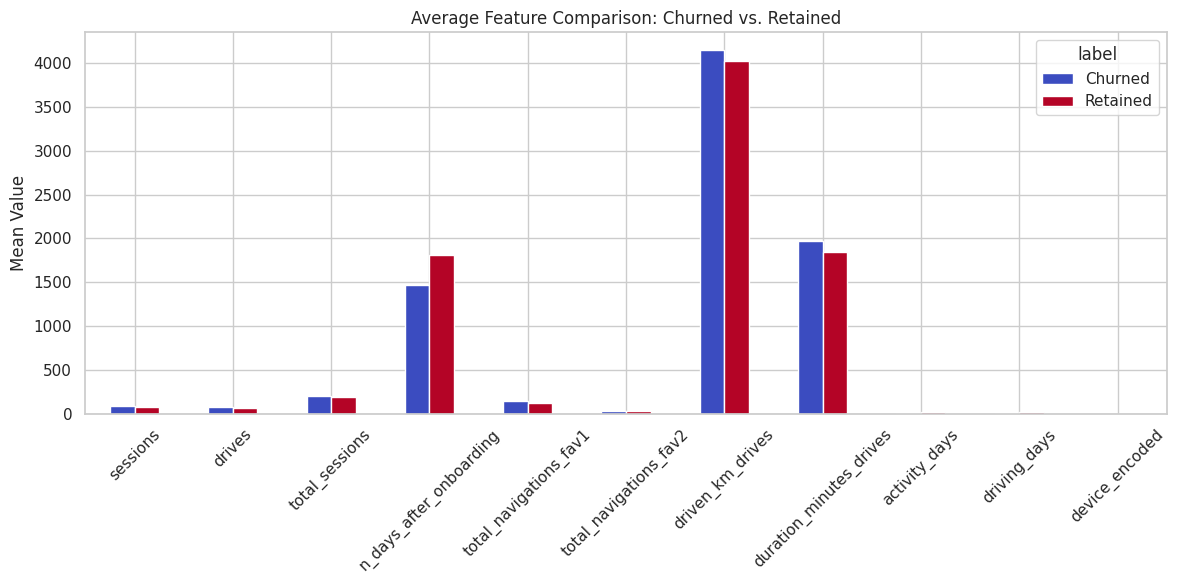

In [199]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add label back for readability
df_clean["label"] = df_clean["churned"].map({1: "Churned", 0: "Retained"})

# Average Drives per Week by Churn Status
plt.figure(figsize=(8, 5))
# Calculate drives per week
df_clean['drives_per_week'] = df_clean['drives'] / (df_clean['driving_days'] / 7)
sns.boxplot(data=df_clean, x="label", y="drives_per_week")
plt.title("Drives per Week: Churned vs. Retained")
plt.show()

# Days Active in App by Churn Status
plt.figure(figsize=(8, 5))
sns.histplot(data=df_clean, x="activity_days", hue="label", kde=True, bins=20)
plt.title("App Active Days Distribution")
plt.show()

# Heatmap of Feature Means by Label
feature_means = df_clean.groupby("label")[X.columns].mean().T
feature_means.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.title("Average Feature Comparison: Churned vs. Retained")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-138846747.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='activity_days', data=df, palette=['green', 'red'])


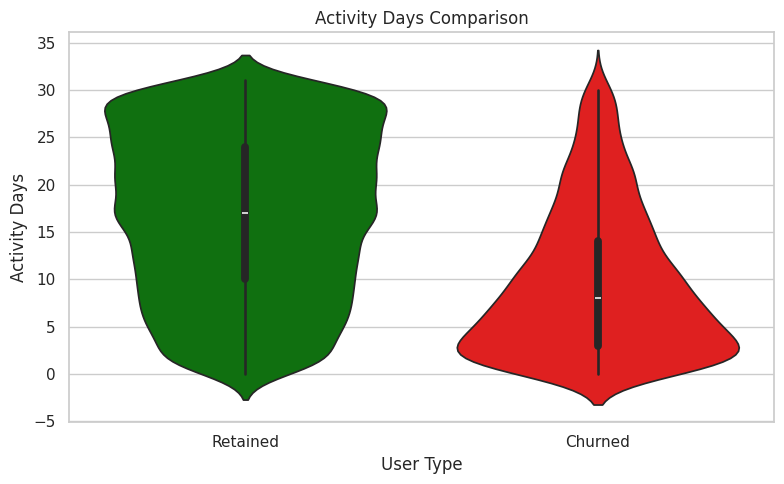

In [200]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='label', y='activity_days', data=df, palette=['green', 'red'])

plt.text(0, df[df['label'] == 0]['activity_days'].max() + 1, f'n={len(df[df["label"] == 0])}',
         ha='center', color='green', weight='bold')
plt.text(1, df[df['label'] == 1]['activity_days'].max() + 1, f'n={len(df[df["label"] == 1])}',
         ha='center', color='red', weight='bold')

plt.xticks([0, 1], ['Retained', 'Churned'])
plt.title('Activity Days Comparison')
plt.xlabel('User Type')
plt.ylabel('Activity Days')
plt.tight_layout()
plt.show()

# Hypothesis Testing

In [201]:
from scipy.stats import ttest_ind, chi2_contingency

# T-test: Drives per week
retained = df_clean[df_clean["label"] == "Retained"]["drives_per_week"]
churned = df_clean[df_clean["label"] == "Churned"]["drives_per_week"]
t_stat, p_val = ttest_ind(retained, churned)
print("T-test for Drives per Week:", "p-value =", p_val)

# T-test: Active days
retained_days = df_clean[df_clean["label"] == "Retained"]["activity_days"]
churned_days = df_clean[df_clean["label"] == "Churned"]["activity_days"]
t_stat, p_val = ttest_ind(retained_days, churned_days)
print("T-test for Active Days:", "p-value =", p_val)

# Chi-square: Device preference
device_ct = pd.crosstab(df_clean["device_encoded"], df_clean["churned"])
chi2, p_val, dof, ex = chi2_contingency(device_ct)
print("Chi-Square Test for Device:", "p-value =", p_val)

T-test for Drives per Week: p-value = nan
T-test for Active Days: p-value = 4.0375361308841995e-303
Chi-Square Test for Device: p-value = 0.7007211845963163


Interpretation: A p-value < 0.05 means a statistically significant difference between churned and retained users for that variable.

# Identify high-risk features

In [202]:
# Top churn-inducing features (from Random Forest)
important_features = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = important_features.sort_values(ascending=False).head(5)
print("Top Predictive Features:\n", top_features)

Top Predictive Features:
 n_days_after_onboarding    0.125415
duration_minutes_drives    0.110088
activity_days              0.106006
driven_km_drives           0.105409
total_sessions             0.105397
dtype: float64


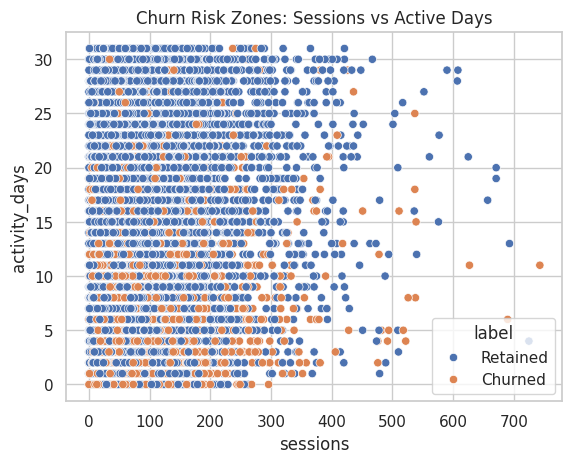

In [203]:
# Scatter plot: Score vs Active Days by churn
sns.scatterplot(data=df_clean, x="sessions", y="activity_days", hue="label")
plt.title("Churn Risk Zones: Sessions vs Active Days")
plt.show()